Authors: Salvatore Mandra (salvatore.mandra@nasa.gov)<br>

Copyright © 2023, United States Government, as represented by the Administrator
of the National Aeronautics and Space Administration. All rights reserved.

The *PySA*, a powerful tool for solving optimization problems is licensed under
the Apache License, Version 2.0 (the "License"); you may not use this file
except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0. 

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

In [1]:
from more_itertools import divide
from multiprocessing import Pool
import matplotlib.pyplot as plt
from time import time, sleep
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

from pysa.sa import Solver
from pysa.ising import get_energy

# Using 'float64' is about ~20% slower
float_type = 'float32'

In [2]:
# Number of variables
n_sweeps = 32
n_vars = 256
n_replicas = 40
n_reads = 100
min_temp = 1.0
max_temp = 3.5

In [3]:
# Generate random problem
problem = 2 * np.random.random((n_vars, n_vars)) - 1
problem = (problem + problem.T) / 2

# Get solver
solver = Solver(problem=problem, problem_type='ising', float_type=float_type)

In [4]:
# Apply Metropolis
res_1 = solver.metropolis_update(
    num_sweeps=n_sweeps,
    num_reads=n_reads,
    num_replicas=n_replicas,
    update_strategy='sequential',
    min_temp=min_temp,
    max_temp=max_temp,
    initialize_strategy='ones',
    recompute_energy=False,
    sort_output_temps=True,
    parallel=True,  # True by default
    verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
# Check that all the energies match
assert (np.alltrue([
    np.isclose(solver.get_energy(x), e, atol=1e-6)
    for xs, es in tqdm(res_1[['states', 'energies']].values)
    for x, e in zip(xs, es)
]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
# Temperatures, initial states and initial energies can be provided
res_1b = solver.metropolis_update(num_sweeps=n_sweeps,
                                  num_reads=n_reads,
                                  update_strategy='sequential',
                                  temps=res_1.loc[0].temps,
                                  initialize_strategy=res_1.loc[0].states,
                                  init_energies=res_1.loc[0].energies,
                                  recompute_energy=False,
                                  sort_output_temps=True,
                                  verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
# Check that all the energies match
assert (np.alltrue([
    np.isclose(solver.get_energy(x), e, atol=1e-6)
    for xs, es in tqdm(res_1b[['states', 'energies']].values)
    for x, e in zip(xs, es)
]))

  0%|          | 0/100 [00:00<?, ?it/s]

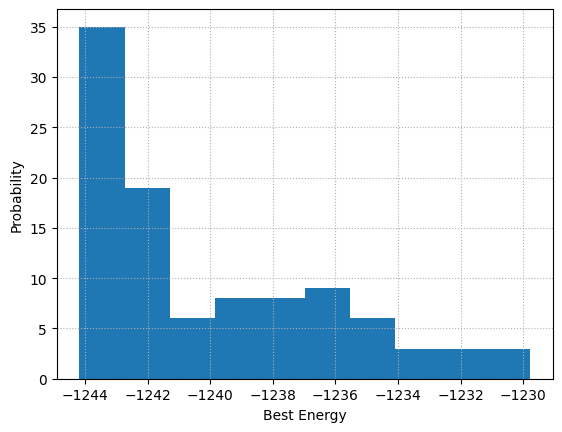

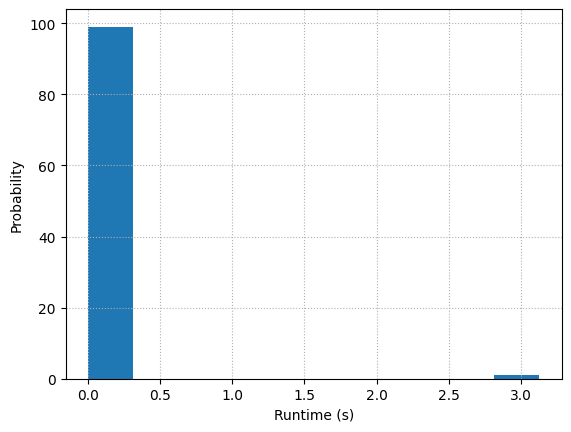

In [8]:
plt.hist(res_1['best_energy'])
plt.grid(ls=':')
plt.xlabel('Best Energy')
plt.ylabel('Probability')
plt.show()

plt.hist(res_1['runtime (us)'] / 1e6)
plt.grid(ls=':')
plt.xlabel('Runtime (s)')
plt.ylabel('Probability')
plt.show()

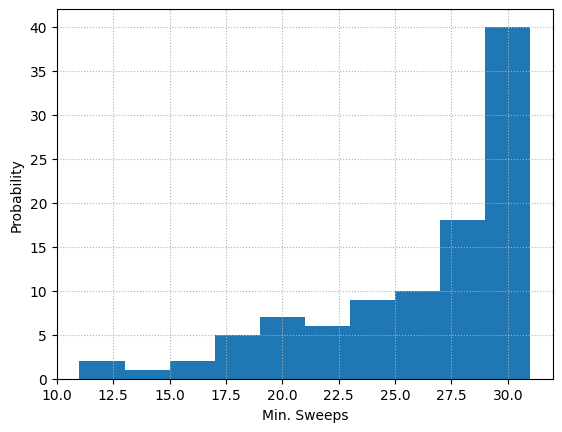

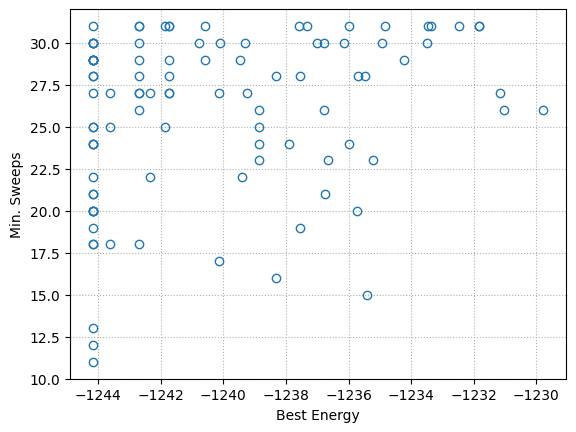

In [9]:
plt.hist(res_1['min_sweeps'])
plt.grid(ls=':')
plt.xlabel('Min. Sweeps')
plt.ylabel('Probability')
plt.show()

plt.plot(*res_1[['best_energy', 'min_sweeps']].values.T, 'o', mfc='none')
plt.xlabel('Best Energy')
plt.ylabel('Min. Sweeps')
plt.grid(ls=':')
plt.show()

In [10]:
# Job can be sent to background 
_handle = solver.metropolis_update(num_sweeps=10 * n_sweeps,
                                   num_reads=n_reads,
                                   num_replicas=n_replicas,
                                   update_strategy='random',
                                   min_temp=min_temp,
                                   max_temp=max_temp,
                                   initialize_strategy='random',
                                   recompute_energy=False,
                                   sort_output_temps=False,
                                   send_background=True,
                                   verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
# It should say that the results are not ready
print(f'Results ready? {_handle.done()}')
res_2 = _handle.result() # This call blocks till the results are ready
print(f'Results ready? {_handle.done()}')

Results ready? False
Results ready? True


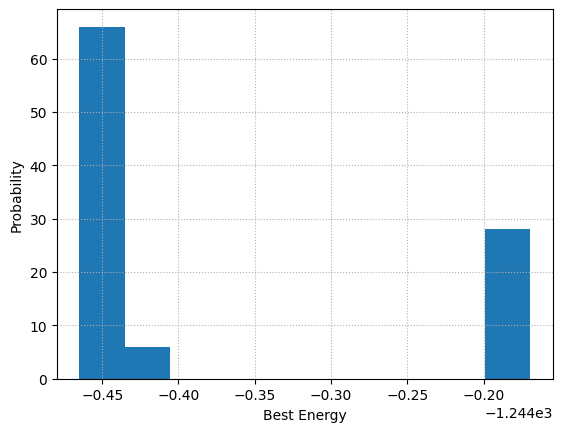

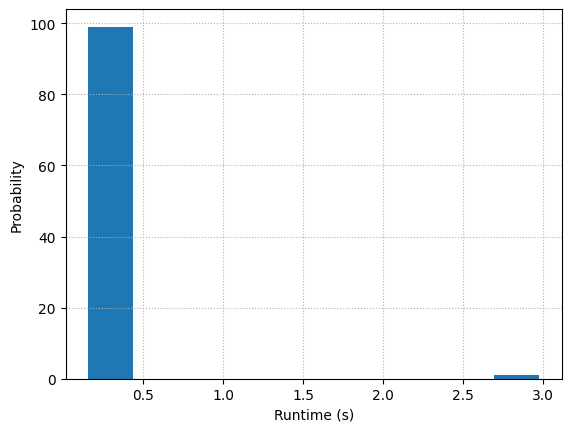

In [12]:
plt.hist(res_2['best_energy'])
plt.grid(ls=':')
plt.xlabel('Best Energy')
plt.ylabel('Probability')
plt.show()

plt.hist(res_2['runtime (us)'] / 1e6)
plt.grid(ls=':')
plt.xlabel('Runtime (s)')
plt.ylabel('Probability')
plt.show()

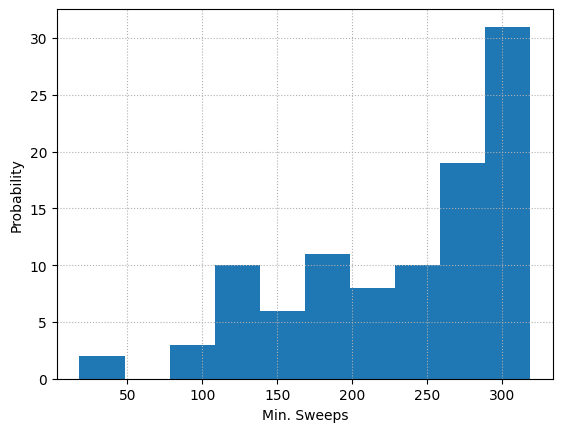

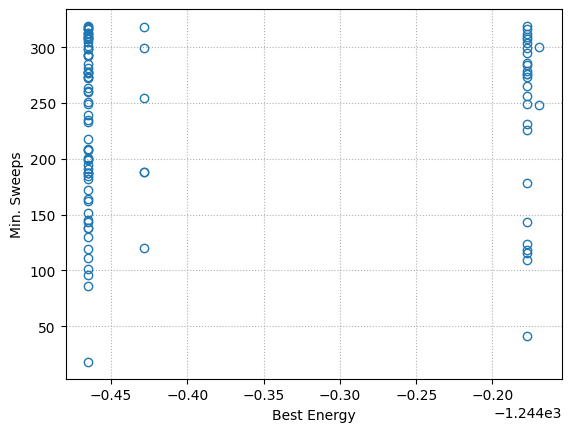

In [13]:
plt.hist(res_2['min_sweeps'])
plt.grid(ls=':')
plt.xlabel('Min. Sweeps')
plt.ylabel('Probability')
plt.show()

plt.plot(*res_2[['best_energy', 'min_sweeps']].values.T, 'o', mfc='none')
plt.xlabel('Best Energy')
plt.ylabel('Min. Sweeps')
plt.grid(ls=':')
plt.show()

In [14]:
# Round-off error can accumulate (if recompute_energy=False)
print(f'Best energy (# sweeps =  {n_sweeps}): {np.min(res_1["best_energy"])}')
print(
    f'Best energy (# sweeps = {10*n_sweeps}): {np.min(res_2["best_energy"])}')

Best energy (# sweeps =  32): -1244.177978515625
Best energy (# sweeps = 320): -1244.4648903980851


In [15]:
# Let's recompute the energy given the best state
print(
    f'Best energy (# sweeps = {n_sweeps}):',
    solver.get_energy(res_1.best_state[np.argmin(res_1.best_energy)])
)
print(
    f'Best energy (# sweeps = {n_sweeps}):',
    solver.get_energy(res_2.best_state[np.argmin(res_2.best_energy)])
)

Best energy (# sweeps = 32): -1244.1775370124506
Best energy (# sweeps = 32): -1244.4648220291078


-----

In [16]:
# Number of variables
n_vars = 32 * 32 * 3
n_replicas = 100

# Generate random problem
problem = 2 * np.random.random((n_vars, n_vars)) - 1
problem = (problem + problem.T) / 2

# Get solver
solver = Solver(problem=problem, problem_type='ising', float_type=float_type)

In [17]:
# Let's define some initial random configurations ...
confs = 2 * np.random.randint(2, size=(n_replicas, n_vars)) - 1

# ... and get the corresponding energies
energies = [solver.get_energy(x) for x in confs]

In [18]:
# Run once to compile
solver.metropolis_update(num_sweeps=1,
                         num_reads=1,
                         update_strategy='sequential',
                         temps=[1] * n_replicas,
                         initialize_strategy=confs,
                         init_energies=energies,
                         recompute_energy=False,
                         sort_output_temps=False,
                         return_dataframe=False,
                         parallel=True,
                         use_pt=False,
                         verbose=False);

In [19]:
%%timeit -n 5 -r 5
_res = solver.metropolis_update(num_sweeps=1,
                                num_reads=1,
                                update_strategy='sequential',
                                temps=[1] * n_replicas,
                                initialize_strategy=confs,
                                init_energies=energies,
                                recompute_energy=False,
                                sort_output_temps=False,
                                return_dataframe=False,
                                parallel=True,
                                use_pt=False,
                                verbose=False)

78.6 ms ± 6.38 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [20]:
_res = solver.metropolis_update(num_sweeps=1,
                                num_reads=1,
                                update_strategy='sequential',
                                temps=[1] * n_replicas,
                                initialize_strategy=confs,
                                init_energies=energies,
                                recompute_energy=False,
                                sort_output_temps=False,
                                return_dataframe=False,
                                parallel=True,
                                use_pt=False,
                                verbose=False)

# Update configurations and energies
confs = _res[0]['states']
energies = _res[0]['energies']

# Let's check that energies are computed correctly
assert (np.alltrue([
    np.isclose(solver.get_energy(c), e, atol=1e-6)
    for c, e in tqdm(zip(confs, energies), total=len(confs))
]))

  0%|          | 0/100 [00:00<?, ?it/s]